# Clinical trials NPs vs. Synthetics

Data from https://clinicalintelligence.citeline.com

Important: it requires a license!

In [1]:
import json
import warnings

import pandas as pd

# from pubchempy import get_compounds

import matplotlib.pyplot as plt

from rdkit import RDLogger

from np_likeness_utils import (
    calculate_percentage_nps_synthetics_hybrids,
    get_np_scores,
    remove_duplicates,
)

In [2]:
warnings.simplefilter(action="ignore", category=FutureWarning)
RDLogger.DisableLog("rdApp.*")

In [3]:
plt.rcParams["figure.dpi"] = 500

Read cache

In [4]:
# read json file from local folder (data)
with open("../../data/clinical_trials/citeline_id_to_smiles_final.json") as json_file:
    citeline_id_to_smiles = json.load(json_file)

Read clinical trials data

Download data from CiteLine as a CSV file and save it in the data folder.

In [5]:
clinical_trials_df = pd.read_csv(
    "../../data/clinical_trials/all_pages_clinical_trials_with_structures.csv",
)

In [6]:
clinical_trials_df.head(2)

,Citeline Drug ID,Generic Drug Name,Global Status,Drug Disease,Drug Disease Group,Drug Disease: Rare,Current Status,Launch Year,Highest Status Reached,Phase I,...,Preclinical,Development Status,Latest Change Date,Latest Change,Delivery Route,Chemical Name,Chemical structure (SMILES format),Trialtrove Trial Count,PubChem CID,Record URL
0,1,carperitide,Launched,"Infarction, myocardial\nRespiratory distress s...",Cardiovascular\nRespiratory\nCardiovascular,\nRare\n,No Development Reported\nNo Development Report...,\n \n1995,Phase III Clinical Trial\nPhase II Clinical Tr...,,...,"In vivo\nIn rats and dogs, it produced renal v...",Widely Launched,6/27/17,Ongoing Phase III development in acute myocard...,"Injectable; Injectable, intravenous",Atriopeptin-28 (human),NaN,51,NaN,https://clinicalintelligence.citeline.com/drug...
1,2,3-deaza-neplanocin A,No Development Reported,"Infection, HIV/AIDS",Anti-infective,,No Development Reported,,Preclinical,,...,"In H9 cells, it upregulated inducible nitric o...",Ceased,5/31/00,Not updated since latest change field introduced,Unspecified,"3-Cyclopentene-1,2-diol, 5-(4-amino-1H-imidazo...",Nc1nccc2n(cnc12)[C@@H]1C=C(CO)[C@@H](O)[C@H]1O...,0,73087,https://clinicalintelligence.citeline.com/drug...


Take a look at the dataset

In [7]:
clinical_trials_df.shape

(100827, 22)

Using this column we can take approved drugs

In [8]:
clinical_trials_df["Development Status"].value_counts()

Ceased             73316
Active             22560
Widely Launched     4951
Name: Development Status, dtype: int64

Let's remove the ones without SMILES

In [9]:
clinical_trials_df["Chemical structure (SMILES format)"].isna().sum()

77050

In [10]:
# Remove those rows
rows_without_structures = clinical_trials_df[
    clinical_trials_df["Chemical structure (SMILES format)"].isna()
]

# Remove those rows
rows_without_structures = clinical_trials_df[
    clinical_trials_df["Chemical Name"].notna()
]

Scrape the structure from those

In [11]:
rows_without_structures.shape

(26581, 22)

### Grounding script

In [12]:
# def get_smiles_from_pubchem(name):
#     try:
#         compound = get_compounds(name, "name")

#     except Exception as e:
#         print(e)
#         return None

#     if len(compound) == 0:
#         return None

#     return compound[0].canonical_smiles

# for _, row in tqdm(
#     rows_without_structures.iterrows(), total=rows_without_structures.shape[0]
# ):
#     # get generic drug name
#     generic_drug_name = row["Generic Drug Name"]
#     # get citeline id
#     citeline_id = row["Citeline Drug ID"]
#     chemical_name = row["Chemical Name"]

#     if not pd.isna(generic_drug_name):
#         smiles_from_generic_name = get_smiles_from_pubchem(generic_drug_name)

#         if smiles_from_generic_name:
#             citeline_id_to_smiles[citeline_id] = smiles_from_generic_name
#             continue

#     if not pd.isna(chemical_name):
#         smiles_from_chemical_name = get_smiles_from_pubchem(chemical_name)

#         if smiles_from_chemical_name:
#             citeline_id_to_smiles[citeline_id] = smiles_from_chemical_name
#             continue

#     citeline_id_to_smiles[citeline_id] = ""

### Stratify by phase

In [13]:
# The ones we know are not approved
rest_clinical_trials = clinical_trials_df[
    clinical_trials_df["Development Status"] != "Widely Launched"
]

In [14]:
approved_smiles_to_include = set()

phase_i_smiles = set()
phase_ii_smiles = set()
phase_iii_smiles = set()

rows = []


def clean_cell(cell):
    return cell.strip().lower()


for index, row in rest_clinical_trials.iterrows():
    (
        citeline_id,
        drug_name,
        status,
        launched_year,
        phase_i,
        phase_ii,
        phase_iii,
        development_status,
        highest_status_reached,
        smiles,
    ) = (
        row["Citeline Drug ID"],
        row["Generic Drug Name"],
        row["Current Status"],
        row["Launch Year"],
        row["Phase I"],
        row["Phase II"],
        row["Phase III"],
        row["Development Status"],
        row["Highest Status Reached"],
        row["Chemical structure (SMILES format)"],
    )

    # Grab the cached smiles if available
    if pd.isna(smiles):
        smiles = citeline_id_to_smiles.get(str(index), None)

        if not smiles:
            continue

    # Preclinical
    if (
        highest_status_reached.strip() == "Preclinical"
        or "preclinical" in status.strip().lower()
    ):
        continue

    """Approved"""
    # Those are actually approved drugs
    if (
        "launched" in status.strip().lower()
        or "launched" in highest_status_reached.strip().lower()
    ):
        approved_smiles_to_include.add(smiles)
        continue

    if "199" in launched_year.strip() or "20" in launched_year.strip():
        approved_smiles_to_include.add(smiles)
        continue

    """Phase I/II/III"""
    if highest_status_reached.strip() == "Phase I Clinical Trial":
        phase_i_smiles.add(smiles)
        continue

    if highest_status_reached.strip() == "Phase II Clinical Trial":
        phase_ii_smiles.add(smiles)
        continue

    if highest_status_reached.strip() == "Phase III Clinical Trial":
        phase_iii_smiles.add(smiles)
        continue

    """Rely on highest status reached"""

    if "phase iii" in highest_status_reached.strip().lower():
        phase_iii_smiles.add(smiles)
        continue

    if "phase ii" in highest_status_reached.strip().lower():
        phase_ii_smiles.add(smiles)
        continue

    if "Phase i" in highest_status_reached.strip().lower():
        phase_i_smiles.add(smiles)
        continue

    unique_status = {stat.strip() for stat in highest_status_reached.split("\n")}

    if len(unique_status) == 1 and list(unique_status)[0] in {
        "Pre-registration",
        "Preclinical",
        "Registered",
    }:
        continue

    if len(unique_status) == 1 and list(unique_status)[0] == "Phase I Clinical Trial":
        phase_i_smiles.add(smiles)
        continue

    if len(unique_status) == 1 and list(unique_status)[0] == "Phase II Clinical Trial":
        phase_ii_smiles.add(smiles)
        continue

    if len(unique_status) == 1 and list(unique_status)[0] == "Phase III Clinical Trial":
        phase_iii_smiles.add(smiles)
        continue

    if "III" in highest_status_reached:
        phase_iii_smiles.add(smiles)
        continue

    if "II" in highest_status_reached:
        phase_ii_smiles.add(smiles)
        continue

    if "I" in highest_status_reached:
        phase_i_smiles.add(smiles)
        continue

    if (
        "preclinical" in highest_status_reached.lower()
        or "registr" in highest_status_reached.lower()
    ):
        continue

    if "Not Applicable" in highest_status_reached:
        continue

    raise ValueError(f"{highest_status_reached} not found in {unique_status}")

In [15]:
(
    len(phase_i_smiles),
    len(phase_ii_smiles),
    len(phase_iii_smiles),
    len(approved_smiles_to_include),
)

(2869, 3843, 1606, 809)

Approved drugs are the ones widely launched, subsetting the smiles

In [16]:
approved_drugs_smiles = clinical_trials_df[
    clinical_trials_df["Development Status"] == "Widely Launched"
]["Chemical structure (SMILES format)"].unique()

approved_drugs_smiles = set(approved_drugs_smiles).union(approved_smiles_to_include)

In [17]:
def remove_salts(smiles):
    if "." in smiles:
        # get the largest molecule
        return sorted(smiles.split("."), key=len)[-1]

    return smiles

In [18]:
# Remove salts
approved_drugs_smiles = [
    remove_salts(smiles) for smiles in approved_drugs_smiles if pd.notna(smiles)
]

In [19]:
len(approved_drugs_smiles)

2983

### Remove duplicates in FDA approved drugs

Now, let's remove duplicates Tanimoto(Morgan fingerprints) > 0.95, things that are super similar and are probably the same

In [20]:
all_approved_drugs_without_duplicates, _ = remove_duplicates(approved_drugs_smiles)

2768 smiles before removing duplicates


100%|██████████| 2897/2897 [00:00<00:00, 18999.08it/s]


1283 duplicates found 44.0% of the total)


In [21]:
len(all_approved_drugs_without_duplicates)

2211

In [22]:
phase_i_smiles = [remove_salts(smiles) for smiles in phase_i_smiles]
phase_ii_smiles = [remove_salts(smiles) for smiles in phase_ii_smiles]
phase_iii_smiles = [remove_salts(smiles) for smiles in phase_iii_smiles]

print(
    len(phase_i_smiles),
    len(phase_ii_smiles),
    len(phase_iii_smiles),
)

# remove from phase i smiles that are in phase ii, iii
phase_i_smiles = [
    smiles
    for smiles in phase_i_smiles
    if smiles not in phase_ii_smiles or smiles not in phase_iii_smiles
]

# remove from phase ii smiles that are in phase iii
phase_ii_smiles = [
    smiles for smiles in phase_ii_smiles if smiles not in phase_iii_smiles
]

print(
    len(phase_i_smiles),
    len(phase_ii_smiles),
    len(phase_iii_smiles),
)

2869 3843 1606
2733 3603 1606


In [23]:
np_likeness_cache = {}
sas_cache = {}
lipinski_cache = {}
np_classifier_cache = {}

### Stratifying by clinical trial phase

In [24]:
phase_i_scores, phase_i_inchikeys, _ = get_np_scores(
    all_smiles=phase_i_smiles,
    skip_duplicate=False,
    skip_np_classifier=True,
    np_classifier_cache=np_classifier_cache,
    np_likeness_cache=np_likeness_cache,
    sas_cache=sas_cache,
    lipinski_cache=lipinski_cache,
)

phase_i_dict = calculate_percentage_nps_synthetics_hybrids(
    phase_i_scores,
    dataset_name="Phase I",
)

phase_ii_scores, phase_ii_inchikeys, _ = get_np_scores(
    all_smiles=phase_ii_smiles,
    skip_duplicate=False,
    skip_np_classifier=True,
    np_classifier_cache=np_classifier_cache,
    np_likeness_cache=np_likeness_cache,
    sas_cache=sas_cache,
    lipinski_cache=lipinski_cache,
)

phase_ii_dict = calculate_percentage_nps_synthetics_hybrids(
    phase_ii_scores,
    dataset_name="Phase II",
)

phase_iii_scores, phase_iii_inchikeys, _ = get_np_scores(
    all_smiles=phase_iii_smiles,
    skip_duplicate=False,
    skip_np_classifier=True,
    np_classifier_cache=np_classifier_cache,
    np_likeness_cache=np_likeness_cache,
    sas_cache=sas_cache,
    lipinski_cache=lipinski_cache,
)

phase_iii_dict = calculate_percentage_nps_synthetics_hybrids(
    phase_iii_scores,
    dataset_name="Phase III",
)

reading NP model ...
model in
 10%|█         | 278/2733 [00:01<00:09, 267.63it/s]

Could not parse smiles: [H][C@@]12Cc3ccc(NC(=O)CN(C)C)c(O)c3C(=O)C1=C(O)[C@]1(O)C(=O)C(C(N)=O)=C(O)[C@@H](N(C)C)[C]1([H])(C)C2


 16%|█▋        | 449/2733 [00:01<00:08, 272.29it/s]

Could not parse smiles: [Cl-][Pt]1([Cl-])([Cl-])([Cl-])[#7]-[#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2-[#7]1


 89%|████████▊ | 2423/2733 [00:09<00:01, 264.00it/s]

Could not parse smiles: S[10B]1234[10B]567[10B]89%10[10B]%11%12%13[10B]585[10B]%118%11[10B]%12%12%14[10B]9%139[10B]16%10[10B]2%129[10B]38%14[10B]475%11


100%|█████████▉| 2724/2733 [00:10<00:00, 284.84it/s]

Could not parse smiles: [H][C@]12SCC(CS[N]3=CNN=[N]3C)=C(N1C(=O)[C@H]2NC(=O)CSC(F)(F)F)C([O-])=O


100%|██████████| 2733/2733 [00:10<00:00, 263.24it/s]
reading NP model ...
model in


0 smiles skipped for less than 4 atoms


  6%|▌         | 220/3603 [00:00<00:12, 266.26it/s]

Could not parse smiles: COc1cc2CC[N@](C)(CCCOC(=O)\C=C(/O)C(=O)OCCC[N@]3(C)C(Cl)Cc4cc(OC)c(OC)cc4[C@H]3Cc3cc(OC)c(OC)c(OC)c3)[C@@H](c3cc(OC)c(OC)c(OC)c3)c2cc1OC


 10%|█         | 365/3603 [00:01<00:11, 284.45it/s]

Could not parse smiles: COc1ccc(cc1)C(=O)[N-]C1=C[N-](=NO1)N1[C@@H](C)CCC[C@H]1C


 14%|█▎        | 489/3603 [00:01<00:10, 300.17it/s]

Could not parse smiles: [Dy+3]1234567[O]=C(NC)C[N]1(CC(=O)[O-]2)CCNCC[N]3(CC(=O)[O-]4)CC(NC)=[O]5


 67%|██████▋   | 2406/3603 [00:08<00:04, 277.65it/s]

Could not parse smiles: CCO\N=C(/C(=O)NC1[C@H]2SCC(SC3SC=C(N=C3)C3=CC=[N](C)C=C3)C(N2C1=O)C(O)=O)c1nsc(NP(O)(O)=O)n1


 76%|███████▌  | 2736/3603 [00:09<00:03, 283.56it/s]

Could not parse smiles: ClC1=CC=CC(=C1)N1CCN(CCCN2Nc3ccccn3C2=O)CC1


 87%|████████▋ | 3119/3603 [00:11<00:01, 295.23it/s]

Could not parse smiles: CC[O-][Ti]123([O-]CC)[O]=C(C)[CH-]C(=[O]1)c1ccccc1


 89%|████████▉ | 3216/3603 [00:11<00:01, 298.38it/s]

Could not parse smiles: ClC1=CC=CC(=C1)N1CCN(CCCN2Nc3ccccn3C2=O)CC1


 93%|█████████▎| 3365/3603 [00:12<00:00, 244.89it/s]

Could not parse smiles: CC(C)[C@H](N)C(=O)O[C@@H]1CC(O[C@H]1CO)[N]1=CCC(N)=NC1=O


100%|██████████| 3603/3603 [00:12<00:00, 277.70it/s]
reading NP model ...
model in


0 smiles skipped for less than 4 atoms


 16%|█▋        | 263/1606 [00:00<00:04, 323.87it/s]

Could not parse smiles: CC(=O)NCCC1=[O][Al+3]([O-])([O-])[O-]C(=O)C(Cc2c[nH]cn2)N1


100%|██████████| 1606/1606 [00:05<00:00, 310.99it/s]

0 smiles skipped for less than 4 atoms


In [25]:
(
    approved_drugs_np_scores,
    approved_drugs_inchikeys,
    approved_drugs_np_classifier,
) = get_np_scores(
    all_smiles=all_approved_drugs_without_duplicates,
    skip_duplicate=False,
    skip_np_classifier=True,
    np_classifier_cache=np_classifier_cache,
    np_likeness_cache=np_likeness_cache,
    sas_cache=sas_cache,
    lipinski_cache=lipinski_cache,
)

approved_drugs_dict = calculate_percentage_nps_synthetics_hybrids(
    approved_drugs_np_scores,
    dataset_name="Approved Drugs",
)

reading NP model ...
model in
100%|██████████| 2211/2211 [00:06<00:00, 329.95it/s]

0 smiles skipped for less than 4 atoms


Plot the trend

In [26]:
# Plot the trend for each of the dictionaries

# create a dataframe with the data
percentages_df = pd.DataFrame(
    [
        phase_i_dict,
        phase_ii_dict,
        phase_iii_dict,
        approved_drugs_dict,
    ],
    index=[
        "phase_1",
        "phase_2",
        "phase_3",
        "approved_drugs",
    ],
)

In [27]:
# rename percentage columns
percentages_df = percentages_df.rename(
    columns={
        "hybrid_percentage": "Hybrid",
        "np_like_percentage": "NP-like",
        "synthetics_percentage": "Synthetic",
    }
)

# rename index
percentages_df.index = [
    "Phase 1",
    "Phase 2",
    "Phase 3",
    "FDA approved",
]

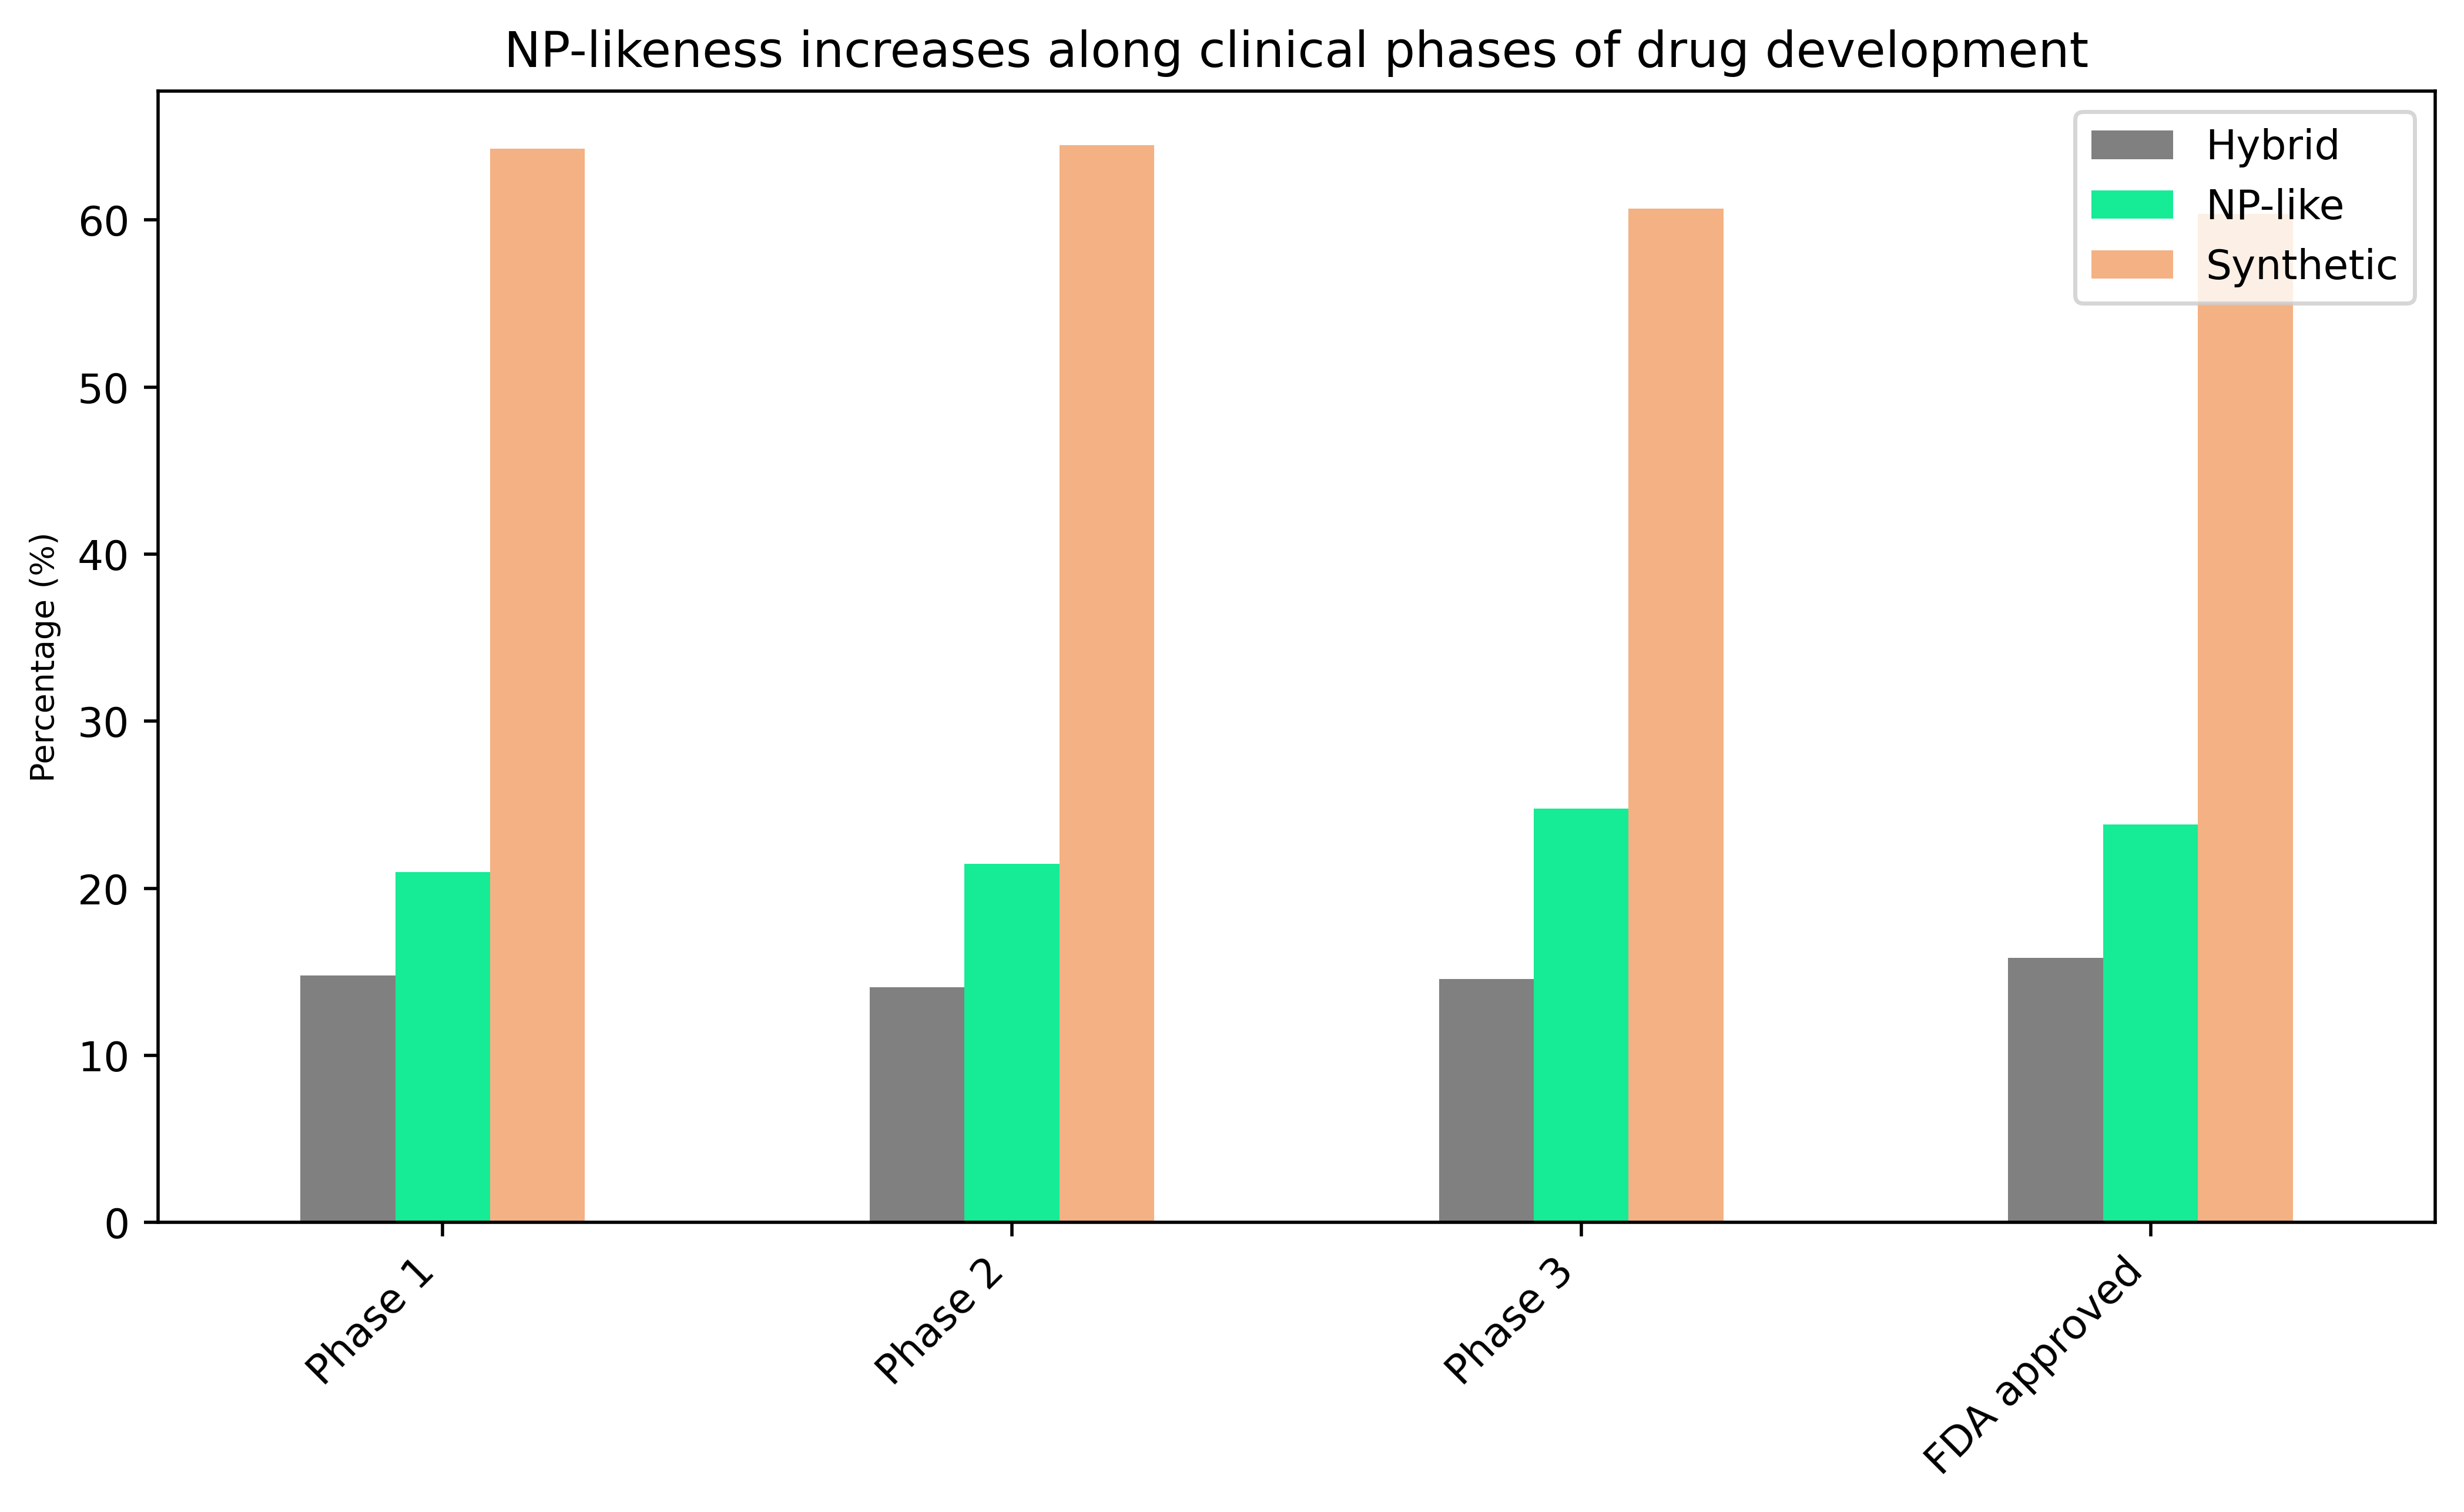

In [28]:
percentages_df.plot.bar(
    rot=0,
    color=[
        "grey",
        "#16EB96",
        "#F4B183",
    ],
    figsize=(10, 5),
)
# Title
plt.title("NP-likeness increases along clinical phases of drug development")

# Y axis
plt.ylabel("Percentage (%)", fontsize=8)
# rotate x axis labels
plt.xticks(rotation=45, ha="right")

# dpi
# plt.savefig("np_likeness_clinical_phases.png", dpi=500)
plt.show()

In [29]:
percentages_df.head(6)

,Hybrid,NP-like,Synthetic
Phase 1,14.78,20.96,64.25
Phase 2,14.06,21.46,64.48
Phase 3,14.56,24.75,60.69
FDA approved,15.82,23.82,60.36


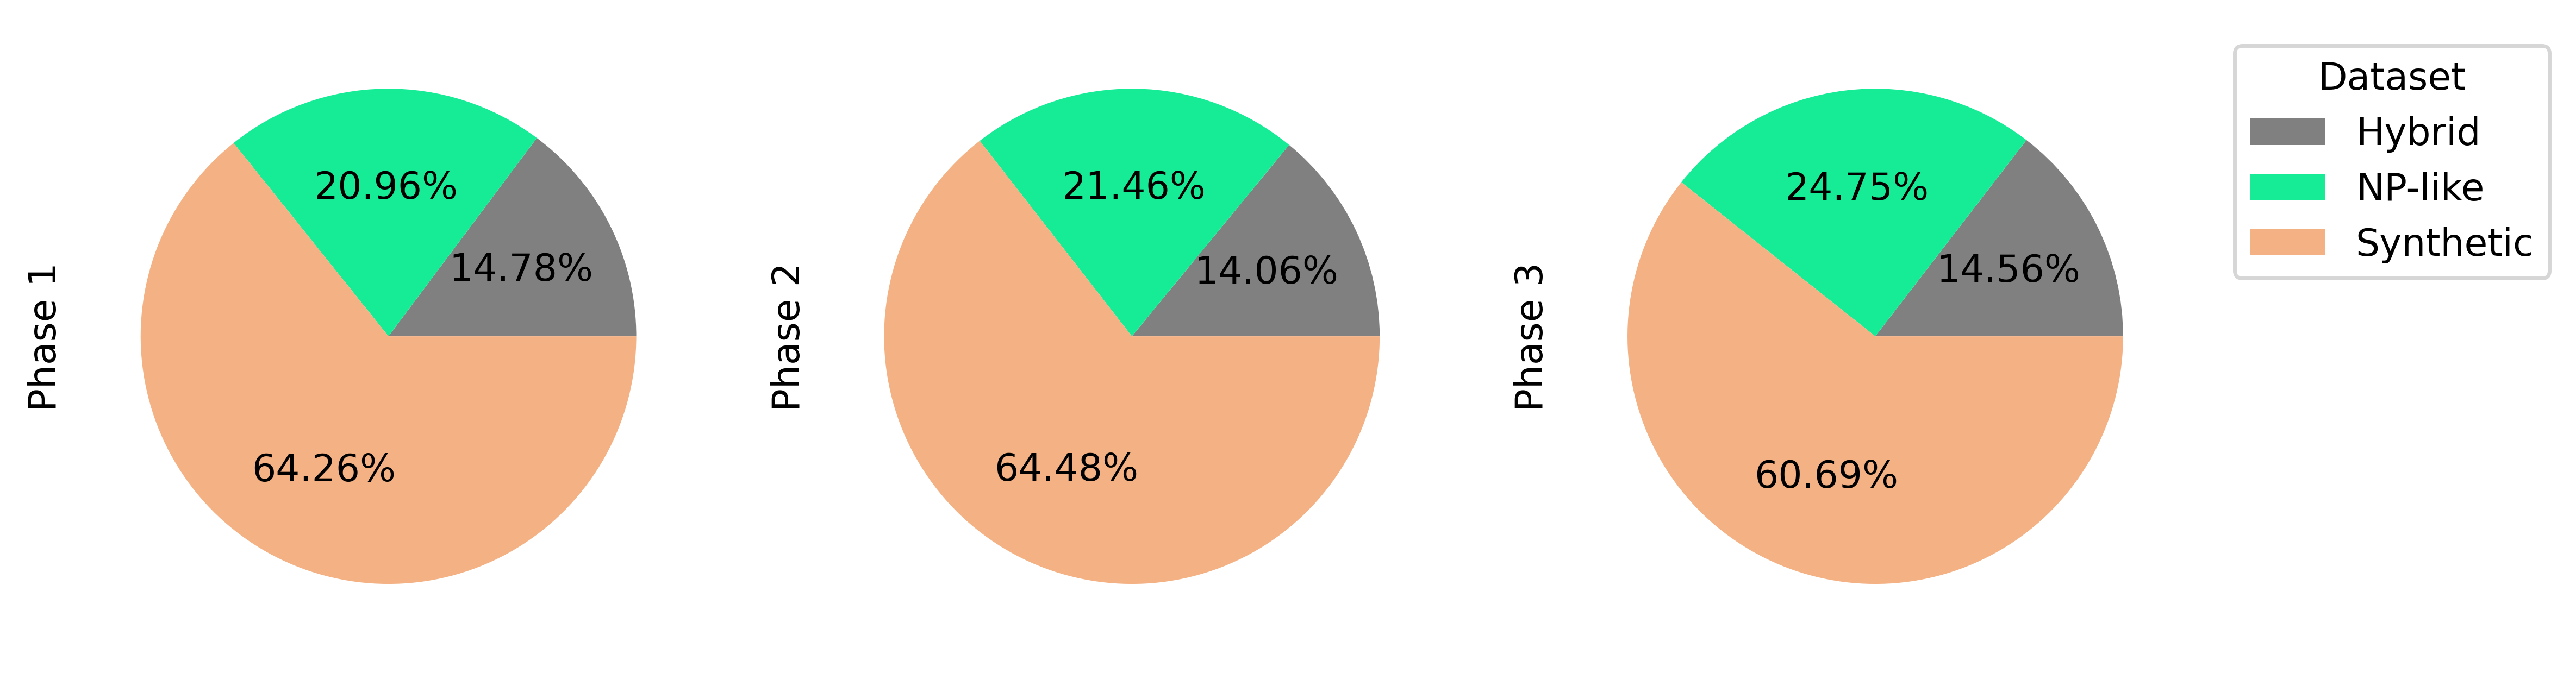

In [30]:
# Plot the pie chart
percentages_df.head(3).T.plot.pie(
    subplots=True,
    figsize=(10, 8),
    colors=[
        "grey",
        "#16EB96",
        "#F4B183",
    ],
    legend=False,
    # remove names on the piechart
    labels=None,
    autopct="%.2f%%",
)


# add one single legend
plt.legend(
    percentages_df.columns,
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    title="Dataset",
)

# decrease font size of the text outside the pie chart
plt.rcParams["font.size"] = 10

plt.show()